<a href="https://colab.research.google.com/github/VigneshBaskar/forfun/blob/master/Copy_of_ECCV2022_Implicitron_Rendering_PUBLIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Renderer and implicit function API

In this demo, we will use the implicit renderer API and the related abstractions.

Often, neural rendering pipeline consists of steps:
1. Ray sampling
2. Evaluating densities and colours
3. Ray marching

While in practice it is used to render learnable implicit functions (evaluated in step 2), here we hard-code it to produce a Phong-shaded ball.

## 0. Install and import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:


In [ ]:
import sys
sys.version

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath visdom==0.1.8.9 omegaconf
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
import base64
from typing import Any, Dict, Tuple

In [ ]:
import numpy as np
import matplotlib.cm
import imageio
import torch
import torch.nn.functional as F
import IPython
from PIL import Image
from pytorch3d.implicitron.models.implicit_function.base import ImplicitFunctionBase
from pytorch3d.implicitron.models.renderer.base import ImplicitronRayBundle, EvaluationMode
from pytorch3d.implicitron.models.renderer.multipass_ea import MultiPassEmissionAbsorptionRenderer
from pytorch3d.implicitron.models.renderer.ray_sampler import AdaptiveRaySampler
from pytorch3d.implicitron.tools import eval_video_trajectory as pt3dtraj
from pytorch3d.implicitron.tools.config import registry, expand_args_fields
from pytorch3d.implicitron.tools.point_cloud_utils import get_rgbd_point_cloud
from pytorch3d.renderer import PerspectiveCameras, look_at_view_transform, ray_bundle_to_ray_points
from pytorch3d.vis.plotly_vis import plot_batch_individually, plot_scene

Define helper functions

In [ ]:
def stitch_tensor_for_vis(tensor, gain=1.0):
    renders = (tensor.data.cpu().numpy()*255.*gain).astype(np.uint8)
    n_rows = 3
    n_images = len(renders)
    n_per_row = -(-n_images // n_rows)

    split = []
    for row in range(n_rows):
        split.append(renders[row*n_per_row:(row+1)*n_per_row])  

    block = np.hstack(np.hstack(split))
    if block.shape[-1] == 1:
        block = block.repeat(3, axis=-1)
    return Image.fromarray(block)

def show_gif(fname):
    """Show a gif in a bento notebook"""
    with open(fname, "rb") as fd:
        b64 = base64.b64encode(fd.read()).decode("ascii")
    return IPython.display.HTML(f'<img src="data:image/gif;base64,{b64}" />')


## 1. Define the hard-coded radiance field

For illustration, we manually define a radiance field, i.e. a function mapping 3D points and viewing directions to density and colour. In practice, you would have some trainable function here (like an MLP or [factorised] voxel tensor).

We define the density that is non-zero within a sphere, ambient colours – one per wedge, and a specular component based on the view direction. You don’t have to understand the details for the purpose of this tutorial.

Input data to the implicit function are represented as a ray bundle.
It is a compressed representation of 3D points and view directions.

```python
@dataclass
class ImplicitronRayBundle:
    origins: torch.Tensor
    directions: torch.Tensor
    lengths: torch.Tensor
    ...
```

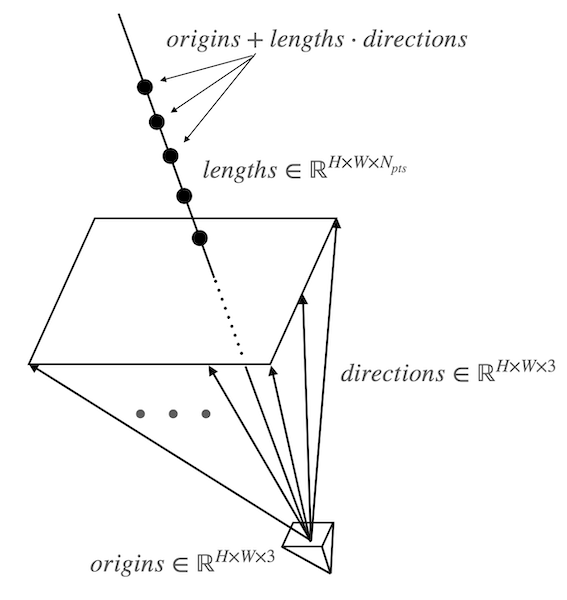

In [ ]:
@registry.register
class ProceduralRadianceField(ImplicitFunctionBase, torch.nn.Module):
    extent: float = 1.0  # In world coordinates, the volume occupies is [-extent, extent] along each axis

    temperature: float = 30.0  # how sharp the density field is
    specularity: float = 1.0

    def __post_init__(self):
        # We have to call this explicitly if there are other base classes like Module
        super().__init__()

    @torch.no_grad()  # in this toy example, we are not learning parameters.
    def forward(
        self,
        ray_bundle: ImplicitronRayBundle,
        fun_viewpool=None,  # these two are not used in many-view (overfitting) scenario
        global_code=None,
    ) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, Any]]:
        # We first convert the ray parametrizations to world coordinates
        rays_points_world = ray_bundle_to_ray_points(ray_bundle)
        # rays_points_world.shape = [minibatch x ... x pts_per_ray x 3]

        # density is zero outside the sphere but linearly increases towards the centre
        density = F.relu(self.temperature * (self.extent - rays_points_world.norm(dim=-1, keepdim=True)))

        # in the ambient component, colour the wedges in XOZ plane, like in a beach ball
        colors = torch.tensor(matplotlib.cm.get_cmap("tab10").colors[:8], device=density.device)
        color_idx = (
            (rays_points_world[..., 0].atan2(rays_points_world[..., 2]) / (2 * np.pi) * len(colors)).floor().long()
        )
        ambient = 0.5 * colors[color_idx, :]

        # specularity component from the standard Phong model
        normals = F.normalize(rays_points_world, dim=-1)
        light_direction = rays_points_world.new_tensor([1.0, 0, 0])
        reflection = 2.0 * F.relu(normals @ light_direction[..., None]) * normals - light_direction
        directions = F.normalize(-ray_bundle.directions, dim=-1)
        specular = 0.5 * F.relu(reflection @ directions[..., None]) ** self.specularity

        features = ambient + specular
        return density, features, {}

## 2. Generate a set of viewpoints

We generate 36 viewpoints around on a circle around the object to create a “zoetrope”.

In [ ]:
IMAGE_RESOLUTION = 150
N_POINTS_PER_RAY = 192
N_CAMERAS = 36
DEVICE = "cuda:0"
#DEVICE = "cpu"

In [ ]:
RT_list = [
    look_at_view_transform(dist=2.5, elev=0.5, azim=angle, degrees=False)
    for angle in np.linspace(0, 2 * np.pi, N_CAMERAS)
]
# collate the list to a batch of PyTorch3D cameras
R, T = [torch.cat(tensor_all_cams, dim=0) for tensor_all_cams in zip(*RT_list)]
cameras = PerspectiveCameras(device=DEVICE, R=R, T=T, focal_length=2.0)

In [ ]:
plot_scene(
    {"main": {"cameras": cameras}},
    camera_scale=0.1,
)

## 3. Create ray bundles and a renderer


Now we need to set up the renderer and sample ray bundles. Renderer and RaySampler normally do not have any learnable parameters.

In [ ]:
# ray sampler object is parametrised by image resolution and number of points per ray
ray_sampler = AdaptiveRaySampler(
    image_width=IMAGE_RESOLUTION, image_height=IMAGE_RESOLUTION, n_pts_per_ray_evaluation=N_POINTS_PER_RAY
).to(DEVICE)
# it turns the viewpoints into a batch of ray bundles
ray_bundle = ray_sampler(
    cameras,
    EvaluationMode.EVALUATION,
    mask=None,
)

# create a renderer object
renderer = MultiPassEmissionAbsorptionRenderer().to(DEVICE)

Finally, instantiate our radiance field and make a forward pass.

In [ ]:
radiance_field = ProceduralRadianceField(extent=1.0, temperature=300.0, specularity=10.0).to(DEVICE)
rendered = renderer(ray_bundle, implicit_functions=[radiance_field])

## 4. Visualise the results

`rendered.features` contain the RGB renders (in general, the renderer supports N-dimensional features that can be decoded after rendering).



In [ ]:
stitch_tensor_for_vis(rendered.features)

In [ ]:
imageio.mimsave('renders.gif', rendered.features.data.cpu().numpy())
show_gif('renders.gif')

In [ ]:
stitch_tensor_for_vis(rendered.depths, gain=0.3)

We now unproject the depth maps, stitch and colour their points, to get the surface in the world coordinates. It is easy to do with Pytorch3D!

In [ ]:
point_cloud = get_rgbd_point_cloud(
    cameras,
    rendered.features.permute(0, 3, 1, 2),
    rendered.depths.permute(0, 3, 1, 2),
    rendered.masks.permute(0, 3, 1, 2),
    mask_thr=0.999999,  # to avoid the noise on the edges of the estimated mask
)

In [ ]:
plot_scene(
    {"main": {"cameras": cameras, "point_cloud": point_cloud}},
    camera_scale=0.1,
    pointcloud_marker_size=2.0,
  )